In [82]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing


In [83]:
data = pd.read_csv("SeoulBikeData.csv",encoding= 'unicode_escape')


In [84]:
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


<AxesSubplot:>

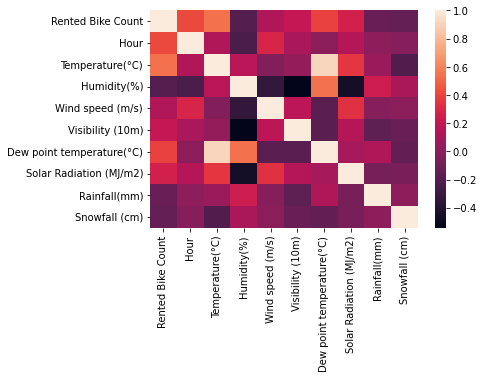

In [85]:
sns.heatmap(data.corr())

yüksek korelasyonlu sütunlardan birini çıkardım

In [86]:
data = data.drop(['Temperature(°C)'], axis = 1)

tarih sütunundan yılları almak için date e çevirdim

In [87]:
data['Date']=pd.to_datetime(data['Date'])


C:\Users\Hasan\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '13/12/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Hasan\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '14/12/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Hasan\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15/12/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Hasan\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16/12/2017' in DD/MM/YYYY format. Provide format or specif

In [88]:
data['Year']=data['Date'].dt.year

date sütununu sildim. Functioning day = no verileri bilgi içermediği için kaldırdım

In [89]:
data= data.drop(['Date'] , axis = 1)
data=data[data['Functioning Day']!='No']

kategorik değişkenler için one hot encoding

In [90]:
data = pd.get_dummies(data, columns = ['Seasons','Holiday','Functioning Day','Hour','Year'], prefix = ['Seasons','Holiday','Functioning Day','Hour','Year'],drop_first=True)

## outlier ları bulma ve silme

In [91]:
cols = data.select_dtypes(include = ["float64","int64"]).columns


In [92]:
for col in cols:
    q1 = data[col].quantile(.25)
    q3 = data[col].quantile(.75)
    IQR = q3 - q1
    lb = q1 - (1.5*IQR)
    ub = q3 + (1.5*IQR)
    upper_outliers = data[data[col] > ub].index
    lower_outliers = data[data[col] < lb].index
    data.drop(upper_outliers,inplace = True)
    data.drop(lower_outliers,inplace = True)


## model without scaling

In [93]:
x = data.drop(['Rented Bike Count'] , axis = 1)
y = data['Rented Bike Count']

In [94]:
 from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [95]:
len(x_train)

4948

In [96]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

print('R-squared:',model.score(x_test, y_test))

R-squared: 0.6971098395257829


In [97]:
n = len(y_test)
y_pred = model.predict(x_test)
mse = sum((y_pred - y_test)**2)/n
print('mse:',mse)

mse: 105006.30404463432


In [98]:
rmse = math.sqrt(mse)
print('rmse:',rmse)

rmse: 324.0467621264473


## With scaling

In [49]:
scx = preprocessing.scale(x)
scy = preprocessing.scale(y)

In [50]:
 from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(scx, scy, test_size=0.25, random_state=42)

In [51]:
model = LinearRegression()
model.fit(x_train, y_train)
print('R-squared:',model.score(x_test, y_test))

R-squared: 0.6969974136508102


In [28]:
n = len(y_test)
y_pred = model.predict(x_test)
mse = sum((y_pred - y_test)**2)/n
mse

0.2916296919719301

In [29]:
rmse = math.sqrt(mse)
rmse

0.5400274918667846

ValueError: x and y must be the same size

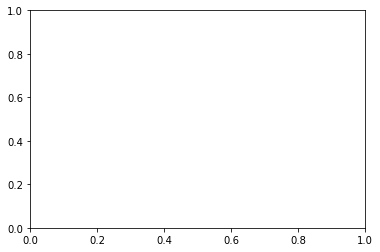

In [31]:
plt.scatter(x_train, y_train,color='g') 

plt.plot(x_test, y_pred,color='k') 

## Statsmodels ve p<0.05 değişkenleri çıkarma

In [23]:
import statsmodels.api as sm
sx_train = sm.add_constant(x_train)
smodel = sm.OLS(y_train,sx_train)
smodel = smodel.fit()

smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     328.7
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:24:28   Log-Likelihood:                -4167.2
No. Observations:                4948   AIC:                             8402.
Df Residuals:                    4914   BIC:                             8624.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.008      0.351      0.725      -0.013       0.019
x1            -0.2950      0.015    -19.113      0.000      -0.325      -0.265
x2            -0.0123      0.009     -1.306      0.192      -0.031       0.006
x3             0.0095      0.010      0.949      0.343      -0.010       0.029
x4             0.4794      0.021     22.612      0.000       0.438       0.521
x5             0.1211      0.016      7.493      0.000       0.089       0.153
x6         -2.309e-17   1.51e-17     -1.532      0.126   -5.26e-17    6.47e-18
x7          1.766e-16   4.65e-17      3.796      0.000    8.54e-17    2.68e-16
x8            -0.1199      0.010    -11.694      0.000      -0.140      -0.100
x9            -0.0835      0.013     -6.306      0.000      -0.109      -0.058
x10           -0.2977      0.015    -19.837      0.000      -0.327      -0.268
x11            0.0445      0.008      5.346      0.000       0.028       0.061
x12           -0.0472      0.012     -4.099      0.000      -0.070      -0.025
x13           -0.0904      0.011     -7.971      0.000      -0.113      -0.068
x14           -0.1259      0.011    -11.355      0.000      -0.148      -0.104
x15           -0.1555      0.011    -13.721      0.000      -0.178      -0.133
x16           -0.1432      0.011    -12.811      0.000      -0.165      -0.121
x17           -0.0812      0.011     -7.120      0.000      -0.104      -0.059
x18            0.0332      0.011      2.959      0.003       0.011       0.055
x19            0.1740      0.011     15.389      0.000       0.152       0.196
x20           -0.0043      0.012     -0.355      0.723      -0.028       0.019
x21           -0.0757      0.012     -6.305      0.000      -0.099      -0.052
x22           -0.0551      0.012     -4.719      0.000      -0.078      -0.032
x23           -0.0499      0.011     -4.408      0.000      -0.072      -0.028
x24           -0.0415      0.011     -3.741      0.000      -0.063      -0.020
x25           -0.0415      0.011     -3.683      0.000      -0.064      -0.019
x26           -0.0161      0.012     -1.368      0.172      -0.039       0.007
x27            0.0228      0.012      1.861      0.063      -0.001       0.047
x28            0.1382      0.012     11.179      0.000       0.114       0.162
x29            0.1791      0.011     16.570      0.000       0.158       0.200
x30            0.1663      0.011     14.886      0.000       0.144       0.188
x31            0.1693      0.011     15.120      0.000       0.147       0.191
x32            0.1753      0.011     15.646      0.000       0.153       0.197
x33            0.1390      0.011     12.227      0.000       0.117       0.161
x34            0.0463      0.011      4.111      0.000       0.024       0.068
x35           -0.0421      0.010     -4.368      0.000      -0.061      -0.023
==

In [24]:
xcol = x.columns
xcol[[1,2,5,6,19,25,26]]

Index(['Wind speed (m/s)', 'Visibility (10m)', 'Rainfall(mm)', 'Snowfall (cm)',
       'Hour_9', 'Hour_15', 'Hour_16'],
      dtype='object')

In [25]:
x = x.drop(['Wind speed (m/s)','Visibility (10m)','Rainfall(mm)','Snowfall (cm)','Hour_9','Hour_15', 'Hour_16'],axis = 1)

In [26]:
scx = preprocessing.scale(x)
scy = preprocessing.scale(y)

x_train, x_test, y_train, y_test = train_test_split(scx, scy, test_size=0.25, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)
print('R-squared:',model.score(x_test, y_test))

R-squared: 0.6957926293224754


In [27]:
n = len(y_test)
y_pred = model.predict(x_test)
mse = sum((y_pred - y_test)**2)/n
mse

0.2927892559439675

regresyon parametlerini daha da geliştirmek için elimizdeki değişkenlerden yeni değişkenler türetebiliriz